<a href="https://colab.research.google.com/github/SerbC/2026S1/blob/main/CadouDePaste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1) Import data - DONE
# 2) Shuffle the data - DONE
# 3) Train test split - DONE
# 4) Preprocess the data:
#     a) normalizare
#     b) resize - DONE-ish
#     c) augumentare - NICE 2 HAVE
#     d) remove/accout4 autliers - Not 4 us
#     e) dataset balancing - Not 4 us
#     f) hand segmentation = Done-ish
#     g) hand extraction - Done-ish
# 5) Feature extraction
# 6) Classifier
# PR, Confusion Matrix, etc

# **ish means do a for loop for all the images

In [ ]:
import numpy as np

import random

def sp_noise(image, prob):

    """

    Add salt and pepper noise to an image.

    Parameters:

        image (numpy.ndarray): Input image array.

        prob (float): Probability of noise (between 0 and 1).

    Returns:

        numpy.ndarray: Image with salt and pepper noise added.

    """

    if not (0 <= prob <= 1):

        raise ValueError("Probability 'prob' must be between 0 and 1.")

    if not isinstance(image, np.ndarray):

        raise TypeError("Input 'image' must be a numpy array.")

    # Create a copy of the image to preserve the original

    output = np.copy(image)

    total_pixels = image.size

    # Calculate the number of salt and pepper pixels

    num_salt = int(total_pixels * prob)

    num_pepper = int(total_pixels * prob)

    # Randomly pick indices for salt and pepper

    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]

    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]

    # Add salt (white pixels)

    output[tuple(salt_coords)] = 255

    # Add pepper (black pixels)

    output[tuple(pepper_coords)] = 0

    return output



0. Import Libs

In [ ]:
import cv2
import numpy as np
import glob
import random
import matplotlib.pyplot as plt

1. Import data (PART 1)

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bp = "/content/drive/MyDrive/fac/Laborator/Images/"
file_path_arr = []
for i in range(4):
  file_path_arr.append(glob.glob(bp+str(i)+'/*.jpg'))
print(file_path_arr)
print(len(file_path_arr))

[['/content/drive/MyDrive/fac/Laborator/Images/0/0.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/1.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/2.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/3.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/4.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/5.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/6.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/7.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/8.jpg', '/content/drive/MyDrive/fac/Laborator/Images/0/9.jpg'], ['/content/drive/MyDrive/fac/Laborator/Images/1/0.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/1.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/2.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/3.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/4.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/5.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/6.jpg', '/content/drive/MyDrive/fac/Laborator/Images/1/7.jpg', '/cont

2) Shuffle the data

In [ ]:
random.seed(42)

In [ ]:
image_index_arr = random.sample(range(0, 9), 7)
print(image_index_arr)

[1, 0, 5, 2, 8, 4, 7]


In [ ]:
train_img_path = []
test_img_path = []

for habd_class in file_path_arr:
  tmp_train = []
  tmp_test = []
  for i in range(10):
    if i not in image_index_arr:
      tmp_test.append(habd_class[i])
    else:
      tmp_train.append(habd_class[i])
  train_img_path.append(tmp_train)
  test_img_path.append(tmp_test)

print(np.shape(train_img_path))
print(np.shape(test_img_path))

(4, 7)
(4, 3)


1. Import data (Part 2)

In [ ]:
train_images = []
test_images = []

for cls in train_img_path:
  t = []
  for i in cls:
    t.append(cv2.imread(i))
  train_images.append(t)

for cls in test_img_path:
  t = []
  for i in cls:
    t.append(cv2.imread(i))
  test_images.append(t)

print(np.shape(train_images))
print(np.shape(test_images))

(4, 7, 4032, 1908, 3)
(4, 3, 4032, 1908, 3)


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7ff50c3c86d0>)

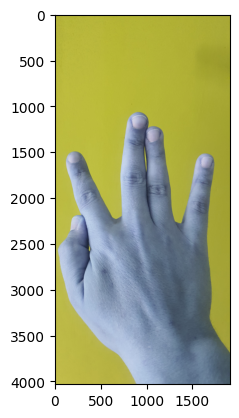

In [ ]:
plt.figure(), plt.imshow(train_images[0][0])

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7ff50c43e350>)

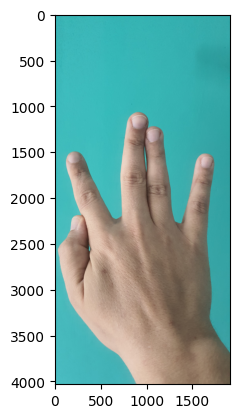

In [ ]:
im = train_images[0][0]
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(), plt.imshow(img_rgb)

4. Preprocess the data

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7ff4e7995950>)

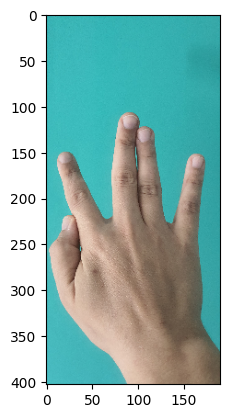

In [ ]:
w, h, _ = np.shape(img_rgb)
scale_dw = 10
img_resized = cv2.resize(img_rgb, (int(h/scale_dw),int(w/scale_dw)))
plt.figure(), plt.imshow(img_resized)

Extragerea mainii folosind culoarea pielii

In [ ]:
# prompt: write a function to segment skin color from images

def segment_skin(image):
    """Segments skin color from an image.

    Args:
        image: A NumPy array representing the input image in RGB format.

    Returns:
        A NumPy array representing the segmented skin region in binary format (0 or 255).
    """
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define the lower and upper bounds for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype="uint8")  # Adjust these values as needed
    upper_skin = np.array([20, 255, 255], dtype="uint8")

    # Create a mask for the skin color range
    mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # Perform morphological operations to refine the mask (optional)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # Fill small holes

    return mask


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7ff4e7a02150>)

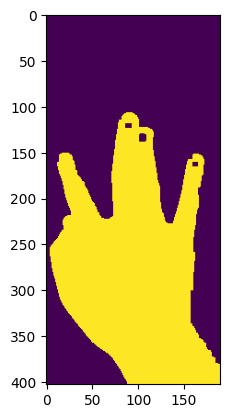

In [ ]:
segmented_skin = segment_skin(img_resized)
plt.figure(), plt.imshow(segmented_skin)

In [ ]:
def binarizare(img):

    R = img[:, :, 0]
    G = img[: ,:, 1]
    B = img[:, :, 2]

    C1 = np.zeros((img.shape[0], img.shape[1]))
    C2 = np.zeros((img.shape[0], img.shape[1]))
    C3 = np.zeros((img.shape[0], img.shape[1]))
    C4 = np.zeros((img.shape[0], img.shape[1]))
    C5 = np.zeros((img.shape[0], img.shape[1]))
    C6 = np.zeros((img.shape[0], img.shape[1]))
    C7 = np.zeros((img.shape[0], img.shape[1]))
    rez = np.zeros((img.shape[0], img.shape[1]))

    C1[np.logical_and(R > 95, G > 40, B > 20)] = 1
    C2[(np.maximum(np.maximum(R, G), B) - np.minimum(np.minimum(R, G), B)) > 15] = 1
    C3[np.absolute(R - G) > 15] = 1
    C4[np.logical_and(R > G, R > B)] = 1

    C5[np.logical_and(R > 220, G > 210, B > 170)] = 1
    C6[np.absolute(R - G) <= 15] = 1
    C7[np.logical_and(R > B, G > B)] = 1


    caz1 = np.logical_and(np.logical_and(C1 == 1, C2 == 1, C3 == 1), C4 == 1)
    caz2 = np.logical_and(C5 ==1, C6 == 1, C7 == 1)

    rez[np.logical_or(caz1 == 1, caz2 == 1)] = 1

    return rez

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7ff4f8793050>)

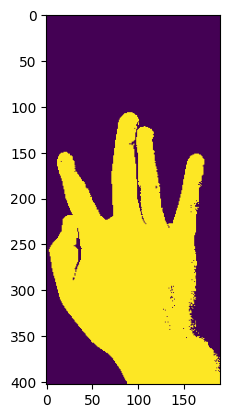

In [ ]:
segmented_skin = binarizare(img_resized)
plt.figure(), plt.imshow(segmented_skin)

In [ ]:
contours, _ = cv2.findContours(segmented_skin.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7ff4e788c190>)

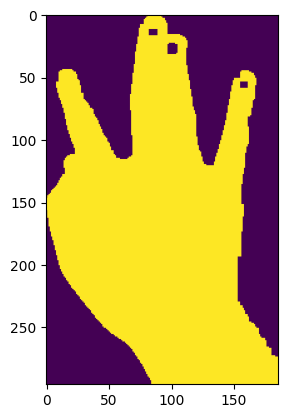

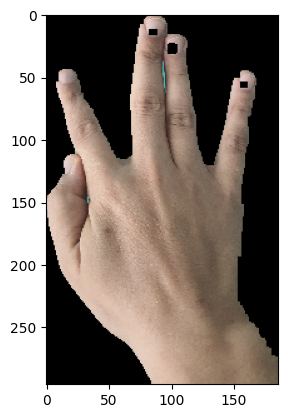

In [ ]:
max_area = 0
max_bbox = None
for contour in contours:
  tmp = cv2.boundingRect(contour)
  arie = tmp[2]*tmp[3]
  if arie>max_area:
    max_area = arie
    max_bbox = tmp
segmented_skin = segmented_skin[max_bbox[1]:max_bbox[1]+max_bbox[3], max_bbox[0]:max_bbox[0]+max_bbox[2]]
img_resized = img_resized[max_bbox[1]:max_bbox[1]+max_bbox[3], max_bbox[0]:max_bbox[0]+max_bbox[2]]
img_resized[segmented_skin == 0] = 0
masked_image = img_resized
plt.figure(), plt.imshow(segmented_skin)
plt.figure(), plt.imshow(masked_image)


In [ ]:
max_area

55352

In [ ]:
max_bbox

(3, 107, 187, 296)